# 01: CMB Data Exploration and Preprocessing

### Introduction

This notebook is the first step in the `CosmicLegacy` research project. The primary goal is to load the Cosmic Microwave Background (CMB) data from the Planck 2018 mission, perform initial visualizations to ensure data integrity, and preprocess it into a format suitable for analysis with deep learning models. We will convert the full-sky spherical map into a dataset of small, 2D image "patches".

### Step 1: Environment Setup

First, we set up the environment by mounting Google Drive for persistent storage and installing the `healpy` library, which is essential for working with CMB data.

In [18]:
# --- Mount Google Drive ---
# This command connects the Colab virtual machine to your personal Google Drive.
# It's essential for saving data, models, and notebooks.
from google.colab import drive
drive.mount('/content/drive')

# --- Install HEALPy ---
# The 'healpy' library is a powerful tool for HEALPix data processing.
# We will use it to read, visualize, and manipulate the CMB sky map.
!pip install healpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 2: Imports and Path Definitions

Here, we import the necessary Python libraries and define the core file paths for our project. This keeps the code organized and easy to manage.

In [19]:
# --- Standard Library Imports ---
import os
import requests
from tqdm.auto import tqdm

# --- Scientific Computing Imports ---
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# --- Path Definitions ---
# Define the absolute path to our project folder on Google Drive.
project_path = '/content/drive/My Drive/CosmicLegacy'
# Define a dedicated sub-folder for storing raw and processed data.
data_path = os.path.join(project_path, 'data')
# Create the data directory if it doesn't already exist.
os.makedirs(data_path, exist_ok=True)

print(f"Project path is set to: {project_path}")
print(f"Data will be stored in: {data_path}")

Project path is set to: /content/drive/My Drive/CosmicLegacy
Data will be stored in: /content/drive/My Drive/CosmicLegacy/data


### Step 3: Data Loading

We will now download the CMB data from the Planck Legacy Archive. The code includes a check to prevent re-downloading the file if it already exists in our Google Drive.

In [20]:
# --- Data Source Definition ---
# This is the direct URL to the full-sky, component-separated SMICA CMB map
# from the Planck 2018 data release (Release 3).
url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits"
file_name = "planck_cmb_map.fits"
file_path = os.path.join(data_path, file_name)

# --- Conditional Download with Progress Bar ---
if not os.path.exists(file_path):
    print(f"CMB map not found. Starting download...")
    try:
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=file_name)
        with open(file_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {file_path}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred during download: {e}")
else:
    print(f"CMB map already exists: {file_path}")

CMB map already exists: /content/drive/My Drive/CosmicLegacy/data/planck_cmb_map.fits


### Step 4: Full-Sky Map Visualization

With the data downloaded, we can now load and visualize the maps. We will plot the Temperature (Intensity) map, as well as the two Polarization maps (Q and U components), to get a complete view of the data.

Loading and visualizing Temperature (I) map...


<Figure size 1200x800 with 0 Axes>

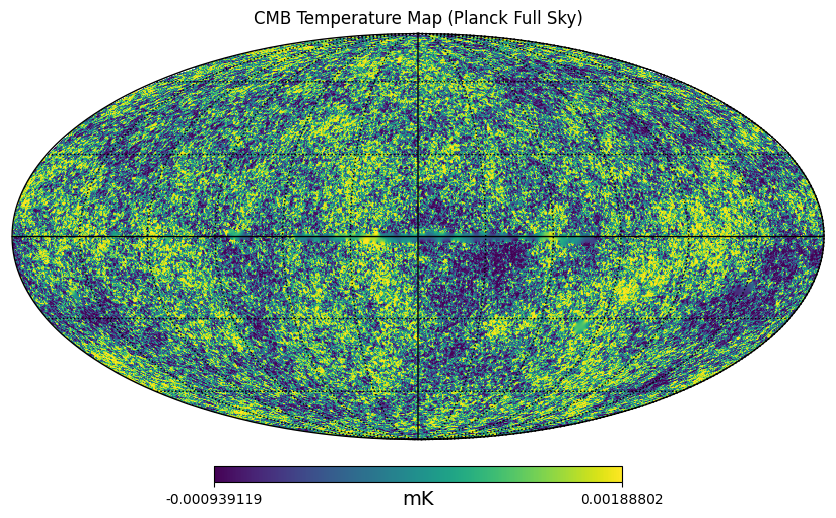


Loading and visualizing Polarization (Q and U) maps...


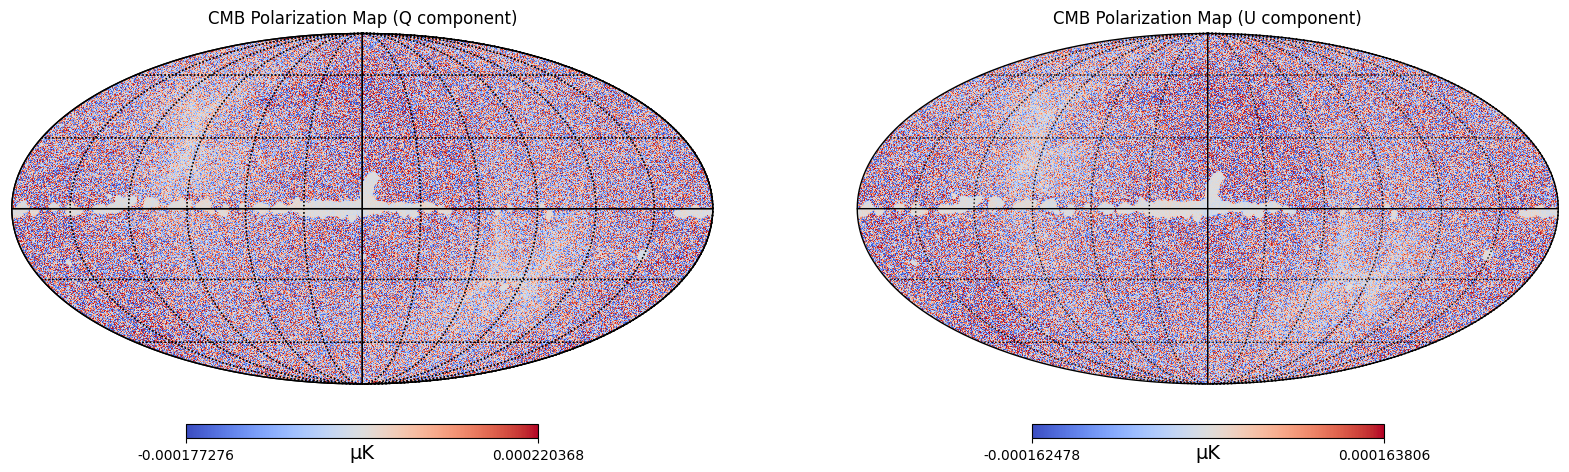

In [21]:
# --- Load and Visualize the Temperature Map ---
print("Loading and visualizing Temperature (I) map...")
cmb_map_I = hp.read_map(file_path, field=0)
plt.figure(figsize=(12, 8))
hp.mollview(cmb_map_I, title="CMB Temperature Map (Planck Full Sky)", unit="mK", norm='hist', cmap='viridis')
hp.graticule()
plt.show()

# --- Load and Visualize the Polarization Maps ---
print("\nLoading and visualizing Polarization (Q and U) maps...")
cmb_map_Q = hp.read_map(file_path, field=1)
cmb_map_U = hp.read_map(file_path, field=2)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
hp.mollview(cmb_map_Q, title="CMB Polarization Map (Q component)", unit="μK", norm='hist', cmap='coolwarm', hold=True)
hp.graticule()
plt.subplot(1, 2, 2)
hp.mollview(cmb_map_U, title="CMB Polarization Map (U component)", unit="μK", norm='hist', cmap='coolwarm', hold=True)
hp.graticule()
plt.show()

### Step 5: Patch Generation

Standard neural networks require 2D images as input. Here, we project small regions of the spherical map onto flat, square "patches". This creates the dataset our model will train on. We will generate patches only from the temperature map for this initial analysis.

Starting patch generation for 5000 patches...


Generating Patches:   0%|          | 0/5000 [00:00<?, ?it/s]


Finished generation. Final dataset shape: (5000, 64, 64)
Displaying a few example patches...


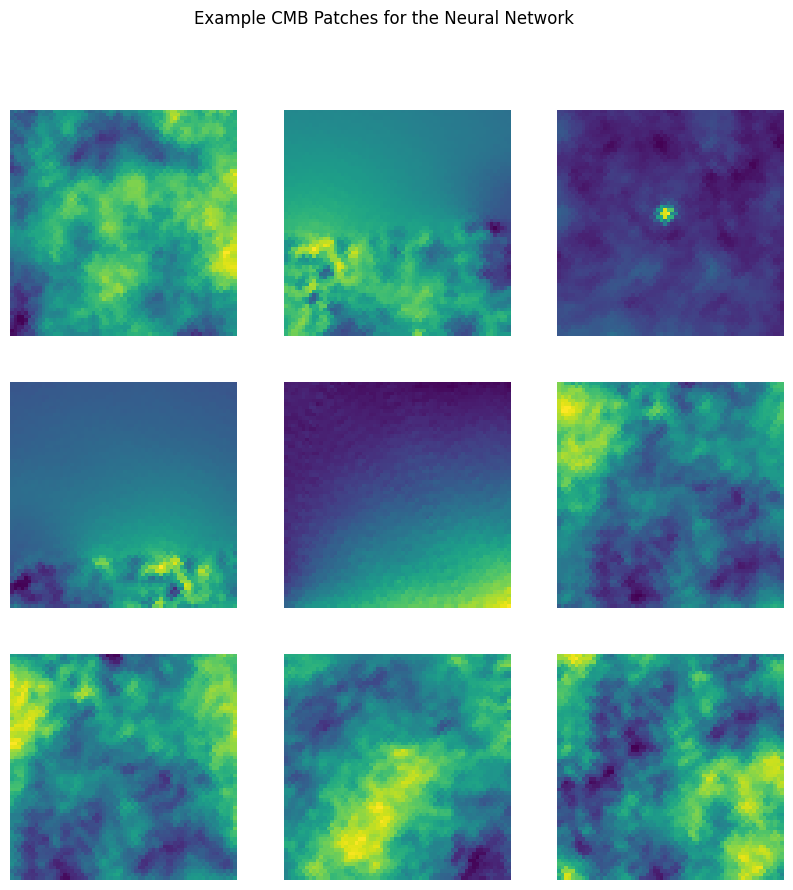

In [22]:
# --- Patch Generation Parameters & Loop ---
patch_resolution_pixels = 64
num_patches_to_generate = 5000
patch_dataset = []
nside = hp.get_nside(cmb_map_I)

print(f"Starting patch generation for {num_patches_to_generate} patches...")
progress_bar = tqdm(total=num_patches_to_generate, desc="Generating Patches")

while len(patch_dataset) < num_patches_to_generate:
    random_pixel_index = np.random.randint(hp.nside2npix(nside))
    projected_map = hp.gnomview(
        cmb_map_I, rot=hp.pix2ang(nside, random_pixel_index),
        xsize=patch_resolution_pixels, reso=1.5,
        return_projected_map=True, no_plot=True
    )
    if np.min(projected_map) > -1e30:
        patch_dataset.append(projected_map)
        progress_bar.update(1)

progress_bar.close()
patch_dataset = np.array(patch_dataset)
print(f"\nFinished generation. Final dataset shape: {patch_dataset.shape}")

# --- Visualize a Few Example Patches ---
print("Displaying a few example patches...")
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(patch_dataset[i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Example CMB Patches for the Neural Network")
plt.show()

### Step 6: Saving the Processed Dataset

Finally, we save the generated patch dataset to our Google Drive. This is a crucial step that prevents us from having to re-run the time-consuming generation process every time we work on the project.

In [23]:
# --- Define the output file path ---
output_filename = "cmb_temperature_patches_5000x64x64.npy"
output_filepath = os.path.join(data_path, output_filename)

# --- Save the array to disk ---
print(f"Saving dataset to: {output_filepath}...")
np.save(output_filepath, patch_dataset)
print("Dataset saved successfully!")

Saving dataset to: /content/drive/My Drive/CosmicLegacy/data/cmb_temperature_patches_5000x64x64.npy...
Dataset saved successfully!


### Conclusion

The data exploration and preprocessing stage is now complete. We have successfully downloaded authentic cosmological data, visualized it to confirm its integrity, and processed it into a clean dataset of image patches. This dataset, `cmb_temperature_patches_5000x64x64.npy`, is now ready and will be the input for our next notebook, where we will build and train an anomaly detection model.